In [7]:
# import os
import pandas as pd
import numpy as np

import torch

from helpers.DatasetProcess import dataset_to_df, search_df
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from pywt import WaveletPacket2D as wp2d
import pywt
import cv2
from skimage.color import rgb2gray

from einops import rearrange, repeat

In [8]:
path = '../../../data/real-vs-fake'
relative_paths = ["/train/real", "/train/fake", "/test/real", "/test/fake", "/valid/real", "/valid/fake"]
paths_classes = ["REAL", "FAKE", "REAL", "FAKE", "REAL", "FAKE"]
# for r_path in relative_paths:
#     remove_fname_space(path + r_path)

df_all, df_train, df_val, df_test, classes_stats = dataset_to_df(
    path, relative_paths, paths_classes, 0.8, 0.19, 0.01)

In [9]:
# path2 = '../../../data/meso_data'
# relative_paths2= ["/Real", "/DeepFake"]
# paths_classes2=['REAL',"FAKE"]


# df_all2, df_train2, df_val2, df_test2, classes_stats2 = dataset_to_df(
#     path2, relative_paths2, paths_classes2, 0.8, 0.19, 0.01)

In [10]:
# search_df(df_all2,"82_678")

In [11]:
def wpt_dec_toFeaturesOnly(img, wavelet_fun, level):
    # This function decomposes the input 2D image into (2**level)**2 2D features
    # hence if we have only one level the output 2D features will be 4
    # The 2D features could be arranged as a matrix of (2**level) rows and (2**level) cols
    # ranging from the most approximate feature at location (0,0) to the most detailed
    # feature at location ((2**level) - 1,(2**level) - 1)
    # The original 2D wave_packet_decompose function down samples the input by 2 after each filter
    # Note: The 2D wave_packet_decompose function deals with a single channel image only.
    # hence you need to take a single channel out of the 3 channel coloured image
    #
    # This function gives the option to output the final features in "stacked" 3D matrix
    # of a shape:
    # if numpy  : (no_of_features x feature_height x feature_width x 3 Channels)
    # if torch  : ((no_of_features x 3 Channels) x feature_height x feature_width)

    TensorOrigin = False
    CHWOrigin = False

    img_one_channel = [0]*3
    wp = [0]*3
    paths = [0]*3

    # Make sure the used Image is numpy array with (Height,Width,Channel) shape.
    if torch.is_tensor(img):
        TensorOrigin = True
        img = img.numpy()

    if img.shape[0] == 3:
        CHWOrigin = True
        Img = rearrange(img, 'c h w -> h w c')

    img_h = img.shape[0]
    features_rows = 2**level

    img_one_channel = [img[:, :, i] for i in range(3)]

    # apply wavelet packet transform
    wp = [wp2d(data=img_one_channel[i], wavelet=wavelet_fun,
               mode='symmetric') for i in range(3)]

    # get the paths of the image
    paths = [node.path for node in wp[0].get_level(level)]

    # Arrange the paths in a 2D matrix shape, useful to visualize the wavelet packet features
    paths_rows = []
    paths_matrix = []
    for i, path in enumerate(paths):
        if (i+1) % features_rows == 0:
            paths_rows.append(path)
            paths_matrix.append(paths_rows)
            paths_rows = []
        else:
            paths_rows.append(path)

    nodes = [[wp[i][path].data for path in paths] for i in range(3)]
    node_shape = wp[0][paths[0]].data.shape
    # nodes_arr = np.transpose(np.array(nodes), (1, 2, 0))
    # axis = 2

    # print("axis", axis) # >>>>>>

    # --->(16, feature_height, feature_width, 3)
    nodes_array = rearrange(np.array(nodes), "c f fh fw -> f fh fw c")

    # --->(16*3, feature_height, feature_width)
    nodes_tensor = torch.tensor(
        rearrange(np.array(nodes), "c f fh fw -> (c f) fh fw"))

    ###############################################################################
    wp_fun = wp[0][paths[0]].wavelet.wavefun()
    # # x, y = wp_fun[-1], wp_fun[0]
    wp_name = wp[0][paths[0]].wavelet.family_name

    return img, nodes_array, paths, features_rows, node_shape, wp_fun, wp_name, nodes_tensor

In [12]:
def plot_img_grid(holder, data, main_title, sub_title=None, Grid2D=True, axes_pad=0.3):

    data_rows = data.shape[0]
    data_cols = data.shape[1]
    if Grid2D:
        nrows = data_rows
        ncols = data_cols
    else:
        nrows = 1
        ncols = data_rows*data_cols

    x_label = range(ncols)
    y_label = range(nrows)

    grid = ImageGrid(holder, 111, (nrows, ncols), axes_pad=axes_pad)

    for i, ax in enumerate(grid):
        r, c = i//data_cols, i % data_cols
        ax.imshow(data[r, c])
        ax.set(xticks=[], yticks=[])
        if Grid2D:
            if r == nrows - 1:
                ax.set_xlabel(x_label[c], rotation=0, fontsize=10, labelpad=20)
            if c == 0:
                ax.set_ylabel(y_label[r], rotation=0, fontsize=10, labelpad=20)
        else:
            ax.set_xlabel(x_label[i], rotation=0, fontsize=10, labelpad=20)
            if i == 0:
                ax.set_ylabel(y_label[i], rotation=0, fontsize=10, labelpad=20)
        if sub_title is not None:
            ax.set_title(sub_title[i])

    holder.suptitle(main_title)


In [13]:
def plot_wp_nodes(image, wavelet_fun, level):
    img, nodes, paths, rows, * \
        _ = wpt_dec_toFeaturesOnly(image, wavelet_fun, level)
    plt.rcParams['figure.constrained_layout.use'] = True
    # plt.rcParams["figure.autolayout"] = True

    fig = plt.figure(figsize=(12, 12))
    subfigs = fig.subfigures(2, 1, height_ratios=[
                             1, 1.5], hspace=0.1, squeeze='True')

    axs0 = subfigs[0].subplots(1, 1)
    axs0.imshow(img)
    # axs0.set_xticks([])
    # axs0.set_yticks([])
    axs0.set_title("Image")

    grid_text = "Features extracted using Wavelet Packet Transform"

    nodes_grid = np.reshape(nodes[:, :, :, 0],(int(np.sqrt(nodes.shape[0])),-1,nodes.shape[1],nodes.shape[2]))

    plot_img_grid(subfigs[1], nodes_grid, grid_text, paths, Grid2D=True)

In [14]:
def plot_wp_fun(image, wavelet_fun, level):
    *_,wp_fun, wp_name,_ = wpt_dec_toFeaturesOnly(image, wavelet_fun, level)

    fig, axs = plt.subplots(1, 3, figsize=(10, 3), layout='constrained')

    axs[0].plot(wp_fun[-1], wp_fun[0])
    axs[0].grid(True)
    axs[0].set_title(f'{wavelet_fun}')

    w = pywt.Wavelet(wavelet_fun)
    (phi, psi, x) = w.wavefun(level=level)

    axs[1].plot(x, phi)
    axs[1].grid(True)
    axs[1].set_title(f'{wavelet_fun} phi')

    axs[2].plot(x, psi)
    axs[2].grid(True)
    axs[2].set_title(f'{wavelet_fun} psi')

In [15]:
# image = plt.imread(df_all.iloc[2937, 0])
image = plt.imread(df_all.iloc[2937, 0])
print("input image shape", image.shape)

input image shape (256, 256, 3)


In [16]:
w_family = pywt.families()
wavelet_lst = []
for i, w_fun in enumerate(w_family):
    wavelet_lst.append(pywt.wavelist(w_fun))
    formatted_w_fun = f'{i}) {w_fun}: {", ".join(pywt.wavelist(w_fun))}'
    print(formatted_w_fun)
print(" \n")

0) haar: haar
1) db: db1, db2, db3, db4, db5, db6, db7, db8, db9, db10, db11, db12, db13, db14, db15, db16, db17, db18, db19, db20, db21, db22, db23, db24, db25, db26, db27, db28, db29, db30, db31, db32, db33, db34, db35, db36, db37, db38
2) sym: sym2, sym3, sym4, sym5, sym6, sym7, sym8, sym9, sym10, sym11, sym12, sym13, sym14, sym15, sym16, sym17, sym18, sym19, sym20
3) coif: coif1, coif2, coif3, coif4, coif5, coif6, coif7, coif8, coif9, coif10, coif11, coif12, coif13, coif14, coif15, coif16, coif17
4) bior: bior1.1, bior1.3, bior1.5, bior2.2, bior2.4, bior2.6, bior2.8, bior3.1, bior3.3, bior3.5, bior3.7, bior3.9, bior4.4, bior5.5, bior6.8
5) rbio: rbio1.1, rbio1.3, rbio1.5, rbio2.2, rbio2.4, rbio2.6, rbio2.8, rbio3.1, rbio3.3, rbio3.5, rbio3.7, rbio3.9, rbio4.4, rbio5.5, rbio6.8
6) dmey: dmey
7) gaus: gaus1, gaus2, gaus3, gaus4, gaus5, gaus6, gaus7, gaus8
8) mexh: mexh
9) morl: morl
10) cgau: cgau1, cgau2, cgau3, cgau4, cgau5, cgau6, cgau7, cgau8
11) shan: shan
12) fbsp: fbsp
13) cmo

In [17]:
level = 2

i = 0  # index of the main wavelet category
j = 0  # index of the sub wavelet function
wavelet_fun = wavelet_lst[i][j]
# wavelet_fun = 'db2'
print("Used Wavelet function:", wavelet_fun, "\n")

Used Wavelet function: haar 



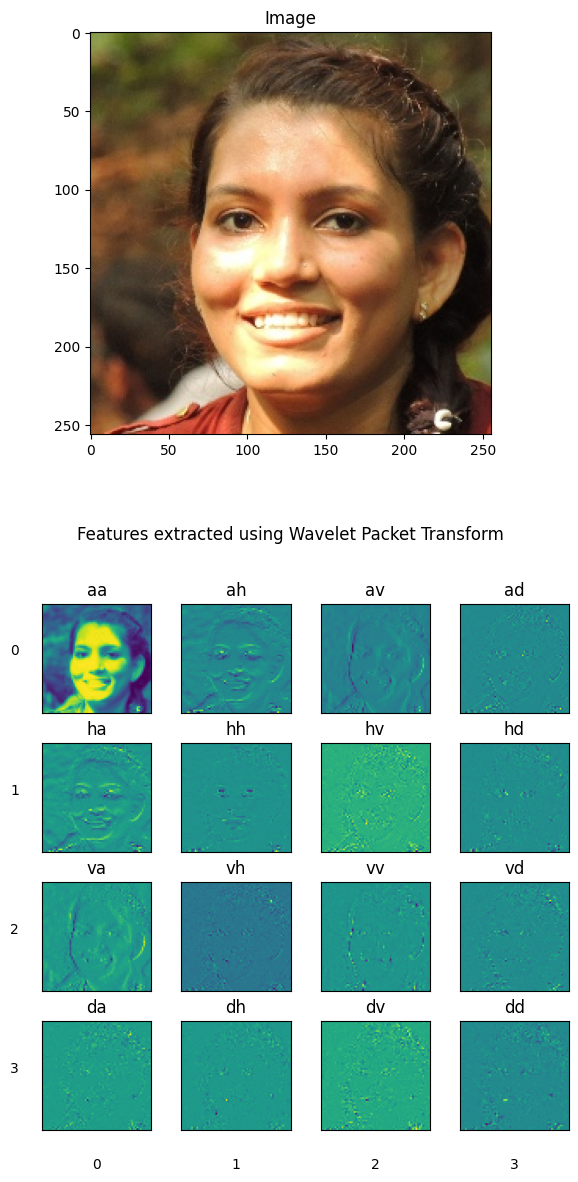

In [18]:
Img, nodes, paths, rows, nodeshape, wp_fun, wp_name, * \
    _ = wpt_dec_toFeaturesOnly(image, wavelet_fun, level)


plot_wp_nodes(image, wavelet_fun, level)

In [19]:
print(nodeshape)

(64, 64)


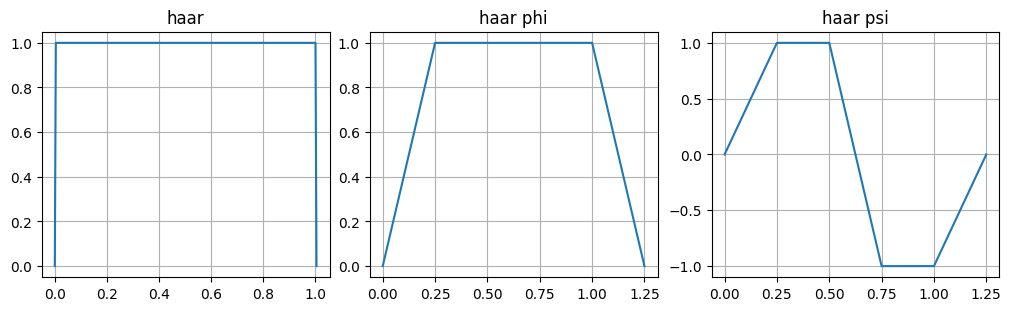

In [20]:
plot_wp_fun(image, wavelet_fun, level)